In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from kan import KAN, create_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [348]:
def hamiltonian(N, t, lambda_, phi, sigma, kappa):
    H = np.zeros((N, N), dtype=complex)
    for n in range(N):
        H[n, (n + 1) % N] = t
        H[(n + 1) % N, n] = t
        H[n, n] = lambda_ * np.cos(2 * np.pi * n * sigma + phi)
    return H

def inverse_participation_ratio(eigenstate):
    return np.sum(np.abs(eigenstate)**4) / (np.sum(np.abs(eigenstate)**2)**2)

def fractal_dimension(IPR, N):
    return -np.log(IPR) / np.log(N)

# Parameters to generate the data
N = 50  # System size, number of grids
t = 1.0  # only nearest neighbor hopping is allowed
b = 2/(1 + np.sqrt(5))  # Inverse of golden ratio as irrational number
phi = 0 # phase of the quasi-periodic potential
kappa = 1  # interval of the quasi-periodic potential
lambdas = np.linspace(0.0, 4, 300)  # eange of lambda values
#lambdas = np.linspace(1.5, 2.5, 11)  # eange of lambda values
data = []

for lambda_ in lambdas:
    H = hamiltonian(N, t, lambda_, phi, b, kappa)
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    for i, E in enumerate(eigenvalues):
        IPR = inverse_participation_ratio(eigenvectors[:, i])
        D_k = fractal_dimension(IPR, N)
        localization_indicator = -1 if D_k < 0.5 else 1  # Arbitrary threshold for localization
        data.append([E, lambda_, localization_indicator])

data = np.array(data)
df = pd.DataFrame(data, columns=['energy', 'lambda', 'localization_indicator'])
#df.to_csv('anderson.csv', index=False)

In [349]:
df

,energy,lambda,localization_indicator
0,-2.000000,0.0,1.0
1,-1.984229,0.0,1.0
2,-1.984229,0.0,1.0
3,-1.937166,0.0,1.0
4,-1.937166,0.0,1.0
...,...,...,...
14995,4.161081,4.0,-1.0
14996,4.204483,4.0,-1.0
14997,4.256040,4.0,-1.0
14998,4.275895,4.0,-1.0


In [350]:
## Extended 1, Localized -1
print(df['lambda'].value_counts())
df[df['lambda'] == 0.0]['localization_indicator'].value_counts()

lambda
4.000000    50
0.000000    50
0.013378    50
0.026756    50
0.040134    50
            ..
0.200669    50
0.214047    50
0.227425    50
0.240803    50
0.254181    50
Name: count, Length: 300, dtype: int64


localization_indicator
1.0    50
Name: count, dtype: int64

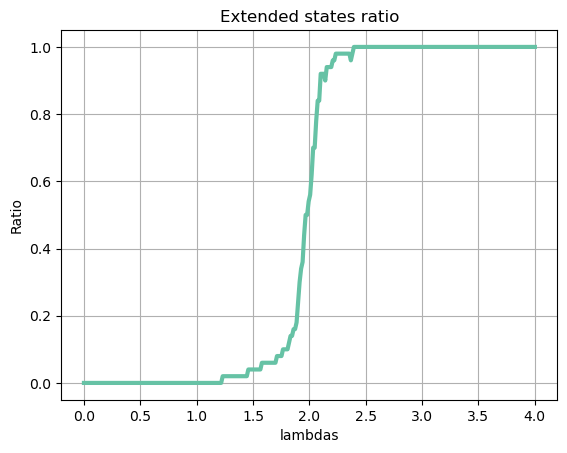

In [394]:
# when lambda is zero, the system is extended all the time
localized = []
lambdas = df['lambda'].value_counts().index.sort_values()
for step in lambdas:
    filtered_df = df[df["lambda"] == step]
    localized.append(np.sum(filtered_df['localization_indicator'] == -1) / 
                     filtered_df.shape[0])
#plt.scatter(lambdas, localized)
# show value of each lambda on the plot, rounding to 2 decimal places
# for (i, j) in zip(lambdas, localized):
#     plt.text(i, j, f"{j:.2f}")
plt.plot(lambdas, localized, linewidth=3)  # You can adjust the value of linewidth as needed
plt.xlabel('lambdas')
plt.ylabel('Ratio')
plt.title('Extended states ratio')
plt.grid()
plt.show()

In [358]:
# Split the data into training and testing sets
def df_to_fataset (df):
    x = df.iloc[:, :-1][["lambda", "energy"]].to_numpy() # change order to be easier to process
    y = df.iloc[:, -1].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=0.8, 
                                                        random_state=42)

    # Convert data to PyTorch tensors
    train_input = torch.tensor(X_train, dtype=torch.float32)
    test_input = torch.tensor(X_test, dtype=torch.float32)
    train_label = torch.tensor(y_train, dtype=torch.long)
    test_label = torch.tensor(y_test, dtype=torch.long)

    # Return the data as a dictionary
    dataset =  {
        'train_input': train_input,
        'test_input': test_input,
        'train_label': train_label,
        'test_label': test_label
    }
    return dataset

In [359]:
# when lambda is zero, the system is extended all the time
# set manually or using a index
filtered_df = df[df["lambda"] == 0]
# filtered_df = df[df["lambda"] == df["lambda"].value_counts().index[-1]]
print(filtered_df['localization_indicator'].value_counts())

localization_indicator
1.0    50
Name: count, dtype: int64


In [360]:
# generate dataset
dataset = df_to_fataset(df)

In [355]:
dataset['test_input']

tensor([[ 3.0635,  3.5140],
        [ 1.7258,  0.0163],
        [ 3.5184, -2.4802],
        ...,
        [ 3.1438, -2.3043],
        [ 0.8696, -0.2658],
        [ 1.3110,  1.9642]])

In [356]:
iters = 0
scores = np.zeros(iters)
seeds = np.zeros(iters)
for i in range(iters):
    seed = np.random.randint(0, 1000)
    model = KAN(width=[2,1,1], grid=3, k=3, seed= seed)
    model(dataset["test_input"])
    model.fix_symbolic(1,0,0, 'tanh')
    model.fix_symbolic(0,0,0, 'x')
    model.fit(dataset, 
            opt="LBFGS", 
            steps=20, 
            lamb=0.01, 
            lamb_entropy=0.5)
    # this is to take as score just the second of the first layer
    # scores[i] = model.edge_scores[0].squeeze(0)[1].item()
    # this takes the whole model score
    scores[i] = torch.cat([i.flatten() for i in model.edge_scores]).mean()
    seeds[i] = seed

In [330]:
print(seeds[np.argsort(scores)][-3:])
print(np.sort(scores)[-3:])

[ 33.  15. 299.]
[0.548181   0.62396753 0.6496861 ]


In [338]:
[i for i in zip(seeds,scores)]

[(299.0, 0.6496860980987549),
 (499.0, 0.05232352018356323),
 (592.0, 9.953995322575793e-05),
 (15.0, 0.6239675283432007),
 (33.0, 0.5481809973716736),
 (783.0, 0.33976879715919495),
 (207.0, 0.1970713585615158),
 (250.0, 0.036531832069158554),
 (719.0, 0.09825164824724197),
 (732.0, 0.0)]

In [331]:
dataset

{'train_input': tensor([[ 4.7495, -4.8464],
         [ 0.3407, -0.9555],
         [ 0.5311,  1.9843],
         ...,
         [ 0.1703, -1.6219],
         [ 3.1563,  3.4318],
         [ 4.7395, -4.7749]]),
 'test_input': tensor([[ 1.3727, -1.5326],
         [ 4.8096, -3.0656],
         [ 1.9339, -1.8357],
         ...,
         [ 2.8357, -3.1405],
         [ 0.5511,  1.3668],
         [ 1.8537, -2.2573]]),
 'train_label': tensor([-1,  1,  1,  ...,  1, -1, -1]),
 'test_label': tensor([ 1, -1,  1,  ..., -1,  1,  1])}

r2 is 0.6243160367012024
r2 is not very high, please double check if you are choosing the correct symbolic function.
r2 is 0.9931240677833557


train loss: 1.00e+00 | test loss: 1.00e+00 | reg: 1.96e+00 : 100%|██| 30/30 [00:13<00:00,  2.16it/s]


[tensor([[3.5513e-08, 9.9331e-01]]), tensor([[0.9934]])]


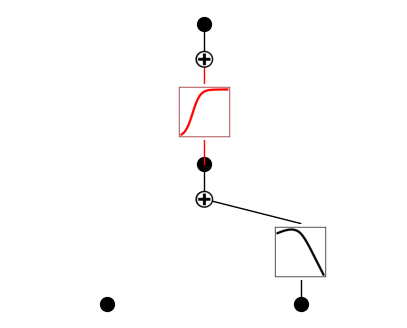

In [369]:
seed = np.random.randint(0, 1000)
#seed = 15
#seed = int(np.sort(scores)[-1])
model = KAN(width=[2,1,1], grid=3, k=2, seed= seed)
model(dataset["train_input"])

model.fix_symbolic(1,0,0, 'tanh')
model.fix_symbolic(0,0,0, 'x')
#model.fix_symbolic(0,1,0, 'gaussian')

model.fit(dataset, 
        opt="LBFGS", 
        steps=30,
        lamb=0.01, 
        lamb_entropy=0.5)
        # loss_fn=torch.nn.CrossEntropyLoss())
print(model.edge_scores)
model.plot(beta=10)

In [370]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Features and target
X = df[['lambda', 'energy']].values
y = df['localization_indicator'].values
pos_weigth = np.sum(y == -1)/np.sum(y == 1) ## to weigth differently 1 and zeros
y = (y + 1)/2 ## go from -1, 1 to 0, 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [371]:
import torch.nn.functional as F

class AliceNet(nn.Module):
    def __init__(self):
        super(AliceNet, self).__init__()
        self.hidden1 = nn.Linear(2, 8)
        self.hidden2 = nn.Linear(8, 16)
        self.hidden3 = nn.Linear(16, 32)
        self.output = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = F.relu(self.hidden3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x

model = AliceNet()



In [372]:
# Calculate the weight for the positive class
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# set a scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/300], Loss: 0.6939
Epoch [20/300], Loss: 0.6347
Epoch [30/300], Loss: 0.5647
Epoch [40/300], Loss: 0.5424
Epoch [50/300], Loss: 0.5336
Epoch [60/300], Loss: 0.5326
Epoch [70/300], Loss: 0.5326
Epoch [80/300], Loss: 0.5316
Epoch [90/300], Loss: 0.5314
Epoch [100/300], Loss: 0.5312
Epoch [110/300], Loss: 0.5312
Epoch [120/300], Loss: 0.5312
Epoch [130/300], Loss: 0.5322
Epoch [140/300], Loss: 0.5305
Epoch [150/300], Loss: 0.5308
Epoch [160/300], Loss: 0.5301
Epoch [170/300], Loss: 0.5305
Epoch [180/300], Loss: 0.5308
Epoch [190/300], Loss: 0.5309
Epoch [200/300], Loss: 0.5314
Epoch [210/300], Loss: 0.5316
Epoch [220/300], Loss: 0.5316
Epoch [230/300], Loss: 0.5310
Epoch [240/300], Loss: 0.5319
Epoch [250/300], Loss: 0.5305
Epoch [260/300], Loss: 0.5314
Epoch [270/300], Loss: 0.5314
Epoch [280/300], Loss: 0.5312
Epoch [290/300], Loss: 0.5318
Epoch [300/300], Loss: 0.5314


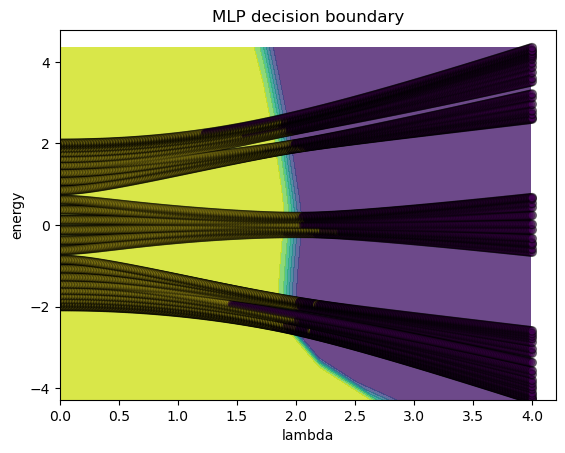

In [373]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = y_pred.round().numpy()

# Plot decision boundary
x_min, x_max = X[:, 0].min() , X[:, 0].max() 
y_min, y_max = X[:, 1].min() , X[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

with torch.no_grad():
    grid_pred = model(grid_tensor)
    grid_pred = grid_pred.reshape(xx.shape)

plt.contourf(xx, yy, grid_pred, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', alpha=0.5, marker='o')
plt.xlabel('lambda')
plt.ylabel('energy')
plt.title('MLP decision boundary')
plt.show()


In [375]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Features and target
X = df[['lambda', 'energy']].values
y = df['localization_indicator'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the SVM, more kernels
#svm = SVC(kernel='linear', probability=True, class_weight='balanced')
#svm = SVC(kernel='rbf', probability=True, class_weight='balanced')  # For RBF kernel
svm = SVC(kernel='poly', degree=3, probability=True, class_weight='balanced') # For polynomial kernel

svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9550
F1 Score: 0.9543


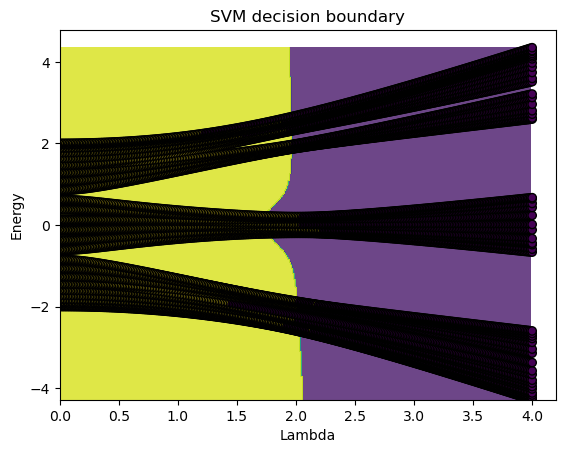

In [378]:
# Create a mesh grid for plotting decision boundary
lambda_min, lambda_max = X[:, 0].min(), X[:, 0].max()
energy_min, energy_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.arange(lambda_min, lambda_max, 0.01),
                     np.arange(energy_min, energy_max, 0.01))

# Predict on the mesh grid
grid = np.c_[xx.ravel(), yy.ravel()]  # Note the order of xx and yy
grid = scaler.transform(grid)  # Apply scaling to the grid
grid_pred = svm.predict(grid)
grid_pred = grid_pred.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, grid_pred, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o')  # Note the order of X[:, 0] and X[:, 1]
plt.xlabel('Lambda')
plt.ylabel('Energy')
plt.title('SVM decision boundary')
plt.show()


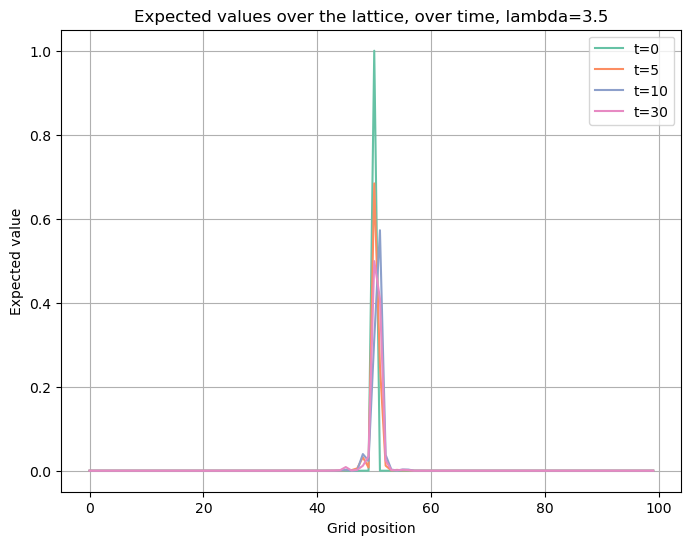

In [311]:
from scipy.linalg import expm

def time_evolution_operator(H, t):
    """Constructs the time evolution operator U(t) = exp(-iHt)"""
    return expm(-1j * H * t)

def expected_values_over_lattice(evolved_state):
    """Calculates the expected values <psi|n|psi> for each grid point n"""
    return np.abs(evolved_state)**2

# set model oarameters
N = 100  
t = 1.0 
phi = (1 + np.sqrt(5)) / 2  
b = phi - 1 
kappa = 1  
lambda_ = 3.5  
times = [0, 5, 10, 30] 

# Initial state (electron at the middle grid point)
initial_state = np.zeros(N, dtype=complex)
initial_state[N//2] = 1.0

H = hamiltonian(N, t, lambda_, phi, b, kappa)
eigenvalues, eigenvectors = np.linalg.eigh(H)

initial_state_eigenbasis = np.dot(eigenvectors.conj().T, initial_state)

# storing the expected values
all_expected_values = []

for t in times:
    # ime evolution operator U(t)
    U_t = time_evolution_operator(H, t)
    evolved_state = np.dot(U_t, initial_state)
    
    # Calculate the expected values for each grid point
    exp_values = expected_values_over_lattice(evolved_state)
    all_expected_values.append(exp_values)

sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
for i, t in enumerate(times):
    plt.plot(np.arange(N), all_expected_values[i], label=f't={t}')
plt.xlabel('Grid position')
plt.ylabel('Expected value')
plt.title(f'Expected values over the lattice, over time, lambda={lambda_}')
plt.legend()
plt.grid(True)
plt.show()


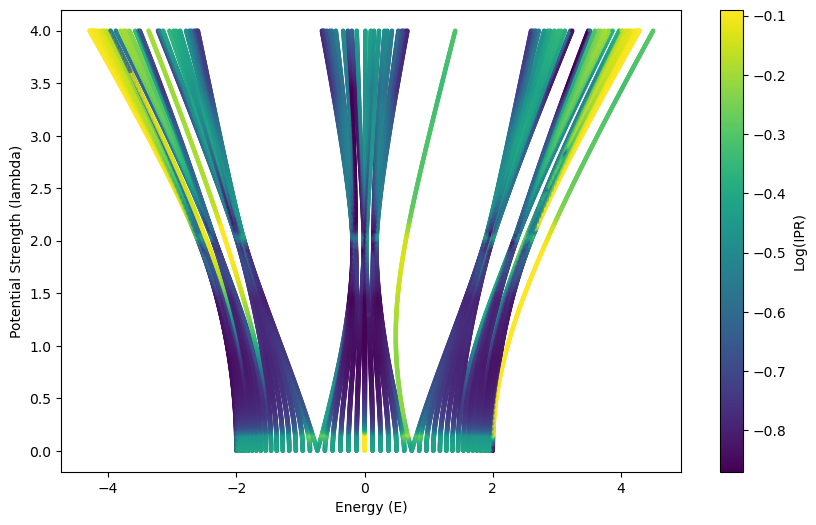

In [396]:
import scipy
N = 100 
t = 1  
phi = 0  
b = 2/(1 + np.sqrt(5))  
kappa = 1  
lambda_values = np.linspace(0, 4, 500)  
E_values = np.linspace(-2*t, 2*t, N)  

data = [] 

for lambda_ in lambda_values:
    H = hamiltonian(N, t, lambda_, phi, b, kappa)
    eigenvalues, eigenvectors = scipy.linalg.eigh(H)
    
    for i, E in enumerate(eigenvalues):
        ipr = inverse_participation_ratio(eigenvectors[:, i])
        data.append([lambda_, E, ipr])

data = np.array(data)

plt.figure(figsize=(10, 6))
for lambda_ in np.unique(data[:, 0]):
    subset = data[data[:, 0] == lambda_]
    plt.scatter(subset[:, 1], subset[:, 0], c=np.log(subset[:, 2]),
                 cmap='viridis', s=5, label=f'lambda={lambda_:.2f}')
plt.colorbar(label='Log(IPR)')
plt.xlabel('Energy (E)')
plt.ylabel('Potential Strength (lambda)')
plt.show()


r2 is 0.9712710380554199
r2 is 0.9640790820121765


train loss: 1.61e-02 | test loss: 1.60e-02 | reg: 1.31e+00 : 100%|██| 30/30 [00:03<00:00,  9.33it/s]


[tensor([[0.9635, 0.2518]]), tensor([[0.9999]])]


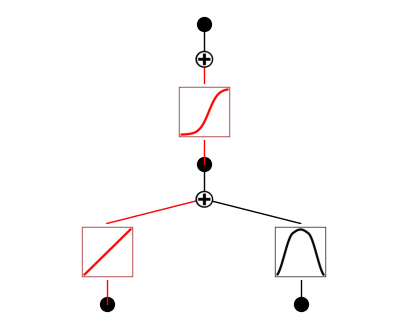

In [2]:
# i want to reproduce a nice function for Anderson loc, to compare

f = lambda x: torch.tanh(((2 * x[:, 0]) -(x[:, 1])**2))
dataset = create_dataset(f, n_var=2, train_num=3000)

model = KAN(width=[2,1,1], grid=3, k=2)
model(dataset["train_input"])
model.fix_symbolic(1,0,0, 'tanh')
model.fix_symbolic(0,0,0, 'x')

model.fit(dataset, 
        opt="LBFGS", 
        steps=30,
        lamb=0.01, 
        lamb_entropy=0.5)
        # loss_fn=torch.nn.CrossEntropyLoss())
print(model.edge_scores)
model.plot(beta=10)